In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import audio_dataset_from_directory
import numpy as np
import librosa
#import tensorflow_io as tfio


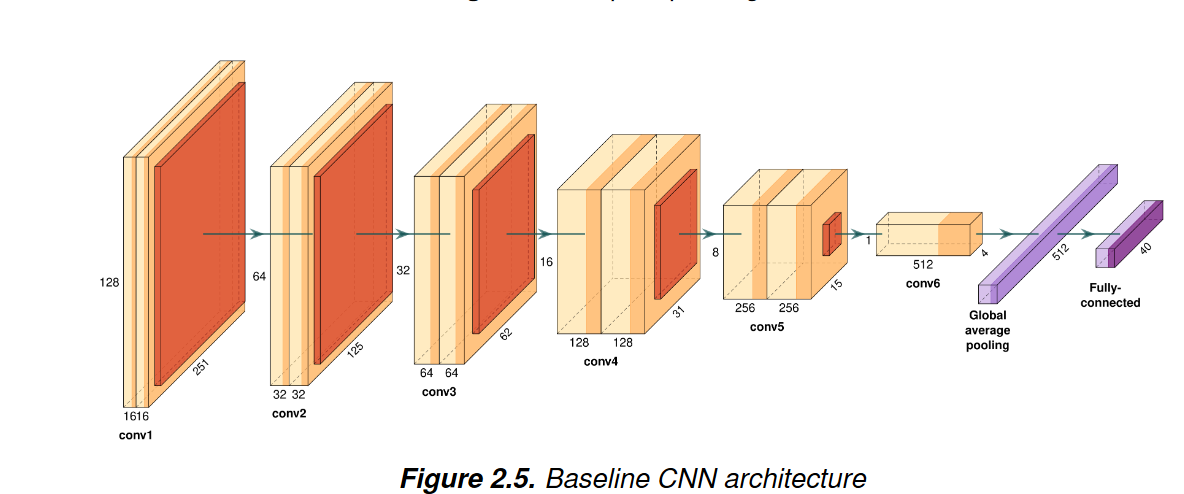

In [ ]:
!gdown 10P678fWDyAJIRv_HlqsXtS2u68NTFZ7I
!unzip data_cnn.zip

In [3]:

data_dir = "/content/data_cnn"

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=None,
    validation_split=0.2,
    seed=0,
    subset='both')

Found 526 files belonging to 3 classes.
Using 421 files for training.
Using 105 files for validation.


In [4]:
train_ds.class_names

['drei', 'eins', 'zwei']

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [4]:
def preprocess_audio(audio, label):
    # Convert audio tensor to a compatible format
    audio = tf.cast(audio, tf.float32)  # Cast audio to float32
    audio = audio / 32768.0  # Normalize audio

    # Extract MFCC features
    def _extract_mfcc(audio):
        # Reshape the audio tensor to (batch_size, num_samples) as expected by librosa
        audio = tf.reshape(audio, [-1])

        # Compute log mel spectrogram
        stfts = tf.signal.stft(audio, frame_length=1024, frame_step=512, fft_length=1024)
        spectrograms = tf.abs(stfts)

        num_spectrogram_bins = stfts.shape[-1]
        lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 40
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz, upper_edge_hertz)

        mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
        log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

        # Compute MFCCs
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)

        return mfccs

    # Use tf.py_function to call _extract_mfcc with audio tensor
    mfccs = tf.py_function(_extract_mfcc, [audio], tf.float32)

    return mfccs, label


In [5]:
train_processed = train_ds.map(preprocess_audio)
val_processed = val_ds.map(preprocess_audio)

In [ ]:
# Example usage of the datasets
for mfccs, labels in train_processed.take(1):
    print("MFCCs shape:", mfccs.shape)
    print("Labels shape:", labels.shape)

MFCCs shape: (402, 40)
Labels shape: ()


In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Find the maximum sequence length in the training dataset
max_length = max(len(seq) for seq, _ in train_processed.as_numpy_iterator())

# Function to pad sequences
def pad_sequence(seq, label):
    padded_seq = tf.pad(seq, paddings=[[0, max_length - tf.shape(seq)[0]], [0, 0]])
    return padded_seq, label

# Pad the training dataset
padded_train_ds = train_processed.map(pad_sequence)

# Pad the validation dataset
padded_val_ds = val_processed.map(pad_sequence)

In [32]:
for mfccs, labels in padded_val_ds.take(5):
    print("MFCCs shape:", mfccs.shape)
    print("Labels shape:", labels.shape)

MFCCs shape: (402, 40)
Labels shape: ()
MFCCs shape: (402, 40)
Labels shape: ()
MFCCs shape: (402, 40)
Labels shape: ()
MFCCs shape: (402, 40)
Labels shape: ()
MFCCs shape: (402, 40)
Labels shape: ()


In [24]:
 # First convolutional bank
model = models.Sequential()
#Input layer of mel-frequency power spectrums of shape (128, 251)
input_shape = (402, 40)
num_classes = 3

#Layer 1
model.add(layers.Conv1D(16, (3, ), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(16, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))

#Layer 2
model.add(layers.Conv1D(32, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(32, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))


#Layer 3
model.add(layers.Conv1D(64, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(64, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))


#Layer 4
model.add(layers.Conv1D(128, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))


#Layer 5
model.add(layers.Conv1D(256, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(256, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))


#Layer 6
model.add(layers.Conv1D(512, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())


#f1
model.add(layers.Conv1D(1024, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())


# Padding to achieve (1, 4, 512) output size
#model.add(layers.ZeroPadding2D(padding=((0, 0), (0, 1))))
# Global average pooling
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics/IoU
# Display model summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 402, 16)           1936      
                                                                 
 batch_normalization_67 (Ba  (None, 402, 16)           64        
 tchNormalization)                                               
                                                                 
 conv1d_71 (Conv1D)          (None, 402, 16)           784       
                                                                 
 batch_normalization_68 (Ba  (None, 402, 16)           64        
 tchNormalization)                                               
                                                                 
 max_pooling1d_33 (MaxPooli  (None, 201, 16)           0         
 ng1D)                                                           
                                                      

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size = 64
train_data = padded_train_ds.batch(batch_size)
val_data = padded_val_ds.batch(batch_size)

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_data,
    epochs=20,
    batch_size=64,
    validation_data=val_data,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 1.1657 - accuracy: 0.5344
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_model.h5
7/7 [==============================] - 29s 3s/step - loss: 1.1657 - accuracy: 0.5344 - val_loss: 1.2099 - val_accuracy: 0.3333
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8812
Epoch 2: val_accuracy did not improve from 0.33333
7/7 [==============================] - 26s 4s/step - loss: 0.3463 - accuracy: 0.8812 - val_loss: 1.6076 - val_accuracy: 0.3333
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9667
Epoch 3: val_accuracy did not improve from 0.33333
7/7 [==============================] - 22s 3s/step - loss: 0.1084 - accuracy: 0.9667 - val_loss: 1.8523 - val_accuracy: 0.3333
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9810
Epoch 4: val_accuracy did not improve from 0.33333
7/7 [==========

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size = 64
train_data = padded_train_ds.batch(batch_size)
val_data = padded_val_ds.batch(batch_size)

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_data,
    epochs=20,
    batch_size=64,
    validation_data=val_data,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 1.7909 - accuracy: 0.3397
Epoch 1: val_accuracy improved from -inf to 0.31429, saving model to best_model.h5
7/7 [==============================] - 32s 3s/step - loss: 1.7909 - accuracy: 0.3397 - val_loss: 1.1197 - val_accuracy: 0.3143
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.7316
Epoch 2: val_accuracy did not improve from 0.31429
7/7 [==============================] - 24s 3s/step - loss: 0.6334 - accuracy: 0.7316 - val_loss: 1.1136 - val_accuracy: 0.3143
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9311
Epoch 3: val_accuracy did not improve from 0.31429
7/7 [==============================] - 23s 3s/step - loss: 0.2153 - accuracy: 0.9311 - val_loss: 1.1998 - val_accuracy: 0.3143
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9810
Epoch 4: val_accuracy did not improve from 0.31429
7/7 [==========

In [4]:
def preprocess_audio_mfps(audio, label):
    # Convert audio tensor to a compatible format
    audio = tf.cast(audio, tf.float32)  # Cast audio to float32
    audio = audio / 32768.0  # Normalize audio

    # Extract mel-frequency power spectra
    def _extract_mel(audio):
        # Reshape the audio tensor to (batch_size, num_samples) as expected by tf.signal.stft
        audio = tf.reshape(audio, [-1])

        # Compute mel-frequency power spectra
        stfts = tf.signal.stft(audio, frame_length=1024, frame_step=512, fft_length=1024)
        spectrograms = tf.abs(stfts)

        num_spectrogram_bins = stfts.shape[-1]
        lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 128
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz, upper_edge_hertz)

        mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)

        return mel_spectrograms

    # Use tf.py_function to call _extract_mel with audio tensor
    mel_spectra = tf.py_function(_extract_mel, [audio], tf.float32)

    return mel_spectra, label

In [5]:
train_processed_mspec = train_ds.map(preprocess_audio_mfps)
val_processed_mspec = val_ds.map(preprocess_audio_mfps)

In [ ]:
for mfps, labels in train_processed_mspec.take(10):
    print("MFPS shape:", mfps.shape)
    print("Labels shape:", labels.shape)

In [6]:

# Find the maximum sequence length in the training dataset
max_length = max(len(seq) for seq, _ in train_processed_mspec.as_numpy_iterator())

# Function to pad sequences
def pad_sequence(seq, label):
    padded_seq = tf.pad(seq, paddings=[[0, max_length - tf.shape(seq)[0]], [0, 0]])
    return padded_seq, label

# Pad the training dataset
padded_train_ds_mfps = train_processed_mspec.map(pad_sequence)

# Pad the validation dataset
padded_val_ds_mfps = val_processed_mspec.map(pad_sequence)

In [8]:
for mfps, labels in padded_train_ds_mfps.take(10):
    print("MFPS shape:", mfps.shape)
    print("Labels shape:", labels.shape)

MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()
MFPS shape: (402, 128)
Labels shape: ()


In [14]:
 # First convolutional bank
model = models.Sequential()
#Input layer of mel-frequency power spectrums of shape (128, 251)
input_shape = (402, 128)
num_classes = 3

#Layer 1
model.add(layers.Conv1D(16, (3, ), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(16, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))

#Layer 2

model.add(layers.Conv1D(32, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
#model.add(layers.Dense(0.5))
model.add(layers.Conv1D(32, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))


#Layer 3
model.add(layers.Conv1D(64, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))


#Layer 4
model.add(layers.Conv1D(128, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))


#Layer 5
model.add(layers.Conv1D(256, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((2, ),strides=(2, )))


#Layer 6
model.add(layers.Conv1D(512, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())


#f1
#model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(1024, (3, ), activation='relu', padding='same'))
model.add(layers.BatchNormalization())


# Padding to achieve (1, 4, 512) output size
#model.add(layers.ZeroPadding2D(padding=((0, 0), (0, 1))))
# Global average pooling
#model.add(flatten())
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics/IoU
# Display model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 402, 16)           6160      
                                                                 
 batch_normalization_17 (Ba  (None, 402, 16)           64        
 tchNormalization)                                               
                                                                 
 dropout_4 (Dropout)         (None, 402, 16)           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 402, 16)           784       
                                                                 
 batch_normalization_18 (Ba  (None, 402, 16)           64        
 tchNormalization)                                               
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 201, 16)          

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
train_data = padded_train_ds_mfps.batch(batch_size)
val_data = padded_val_ds_mfps.batch(batch_size)

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_data,
    epochs=20,
    batch_size=64,
    validation_data=val_data,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 1.3975 - accuracy: 0.3254
Epoch 1: val_accuracy improved from -inf to 0.31429, saving model to best_model.h5
7/7 [==============================] - 30s 3s/step - loss: 1.3975 - accuracy: 0.3254 - val_loss: 1.1031 - val_accuracy: 0.3143


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.5615 - accuracy: 0.3278
Epoch 2: val_accuracy improved from 0.31429 to 0.33333, saving model to best_model.h5
7/7 [==============================] - 20s 3s/step - loss: 1.5615 - accuracy: 0.3278 - val_loss: 1.1144 - val_accuracy: 0.3333
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.4705 - accuracy: 0.3919
Epoch 3: val_accuracy improved from 0.33333 to 0.35238, saving model to best_model.h5
7/7 [==============================] - 21s 3s/step - loss: 1.4705 - accuracy: 0.3919 - val_loss: 1.1452 - val_accuracy: 0.3524
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 1.5170 - accuracy: 0.3610
Epoch 4: val_accuracy did not improve from 0.35238
7/7 [==============================] - 18s 2s/step - loss: 1.5170 - accuracy: 0.3610 - val_loss: 1.1648 - val_accuracy: 0.3333
Epoch 5/20
7/7 [==============================] - ETA: 0s - loss: 1.4374 - accuracy: 0.2945
Epoch 5: val_accuracy did no

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
train_data = padded_train_ds_mfps.batch(batch_size)
val_data = padded_val_ds_mfps.batch(batch_size)

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_data,
    epochs=20,
    batch_size=64,
    validation_data=val_data,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 1.5031 - accuracy: 0.3492
Epoch 1: val_accuracy improved from -inf to 0.35238, saving model to best_model.h5
7/7 [==============================] - 28s 3s/step - loss: 1.5031 - accuracy: 0.3492 - val_loss: 1.1037 - val_accuracy: 0.3524
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.5305 - accuracy: 0.3753
Epoch 2: val_accuracy did not improve from 0.35238
7/7 [==============================] - 18s 2s/step - loss: 1.5305 - accuracy: 0.3753 - val_loss: 1.1056 - val_accuracy: 0.3524
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.4695 - accuracy: 0.3658
Epoch 3: val_accuracy did not improve from 0.35238
7/7 [==============================] - 19s 2s/step - loss: 1.4695 - accuracy: 0.3658 - val_loss: 1.1039 - val_accuracy: 0.3333
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 1.3654 - accuracy: 0.3515
Epoch 4: val_accuracy did not improve from 0.35238
7/7 [==========